# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV
from numpy.random  import RandomState

Откроем файлы с данными по геологоразведке трёх регионов из файлов.

In [4]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

Посмотрим на информацию в файлах. Выведем по 5 строк каждого.

In [5]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В каждом файле по 100000 объектов. Пропусков нет. По типам: ID object, остальные float64. Все ок. Посмотрим на дубли в файлах.

Мы знаем, что: id — уникальный идентификатор скважины;f0, f1, f2 — три признака точек; product — объём запасов в скважине (тыс. баррелей) - это и есть наш таргет - целеой признак.

Посмотрим на дубли в файлах.

In [8]:
i=0
df=[df0,df1,df2]
for df_ in df:
    i += 1
    print(f'{i} регион')
    print(df_.duplicated().sum())

1 регион
0
2 регион
0
3 регион
0


Дублей в файлах нет. 

Посмотрим на уникальные значения.

In [9]:
i=0
df=[df0,df1,df2]
for df_ in df:
    print(f'{i} регион')
    print(df_.nunique())
    i += 1

0 регион
id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64
1 регион
id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64
2 регион
id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64


Во втором регионе очен малое колличество значений таргета product. В связи с чем не понятно. Но остальные значения признаков в стоках уникальные. Посмотрим на дублирующиеся id.

In [10]:
i=0
df=[df0,df1,df2]
for df_ in df:
    print(f'{i} регион')
    print(df_['id'].value_counts())
    i += 1

0 регион
HZww2    2
bsk9y    2
74z30    2
A5aEY    2
AGS9W    2
        ..
np5bq    1
2zKYQ    1
o51nI    1
ODTdt    1
UUvpt    1
Name: id, Length: 99990, dtype: int64
1 регион
wt4Uk    2
LHZR0    2
bfPNe    2
5ltQ6    2
Ki9EX    1
        ..
zjDdN    1
AnZqb    1
fFqTu    1
GPRSn    1
IIUcZ    1
Name: id, Length: 99996, dtype: int64
2 регион
Vcm5J    2
VF7Jo    2
KUPhW    2
xCHr8    2
4ZTue    1
        ..
OhjYy    1
RdNCQ    1
rZDdm    1
ouXf9    1
voB8M    1
Name: id, Length: 99996, dtype: int64


Получается, что в 1ом файле 10 скважин задублировалось. Во втором и 3тьем по 4 скважины. Либо это старые и новые значения, либо, ошибка в названиях, сбой в выгрузке или другом. Проще удалить данные значения. Общее число объектор 10 000. 

In [11]:
double0 = ['HZww2','bxg6G','fiKDv','TtcGQ','AGS9W',
           'A5aEY','Tdehs','QcMuo','74z30','bsk9y']
double1 = ['bfPNe','LHZR0','wt4Uk','5ltQ6']
double2 = ['Vcm5J','VF7Jo','xCHr8','KUPhW']
for doub in double2:
    df2 = df2[df2['id']!=doub]
for doub in double1:
    df1 = df1[df1['id']!=doub]
for doub in double0:
    df0 = df0[df0['id']!=doub]    

Посмотрим на значения тепреь.

In [12]:
i=0
df=[df0,df1,df2]
for df_ in df:
    print(f'{i} регион')
    print(df_.nunique())
    i += 1

0 регион
id         99980
f0         99980
f1         99980
f2         99980
product    99980
dtype: int64
1 регион
id         99992
f0         99992
f1         99992
f2         99992
product       12
dtype: int64
2 регион
id         99992
f0         99992
f1         99992
f2         99992
product    99992
dtype: int64


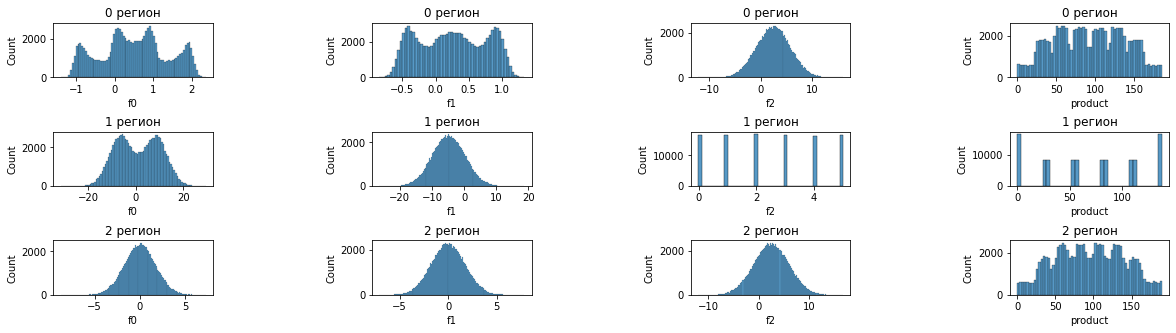

In [13]:
i=-1
df=[df0,df1,df2]
columns =['f0', 'f1', 'f2', 'product']
fig, ax = plt.subplots(3, 4, figsize=(20,5) )
plt.subplots_adjust(wspace=1, hspace=1)
for df_ in df:
    i +=1
    j=0
    for col in columns: 
        sns.histplot(data=df_[col],ax=ax[i][j]).set(title=str(i)+' регион')
        j +=1     

Если смотреть на распределения. Выделяются значения f2 и product во втором регионе.М знаем, что там всего 12 значений ЦП. А вот распределение фича f2 кажутя странными и сильн отличающимися от остальных.

Посмотрим на матрицу корреляции признаков. 

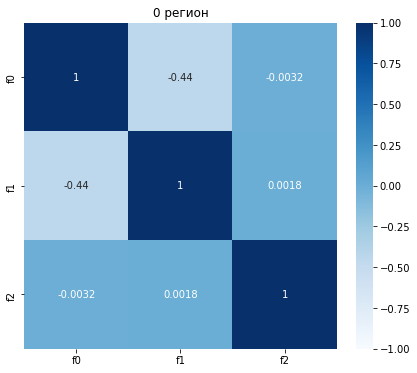

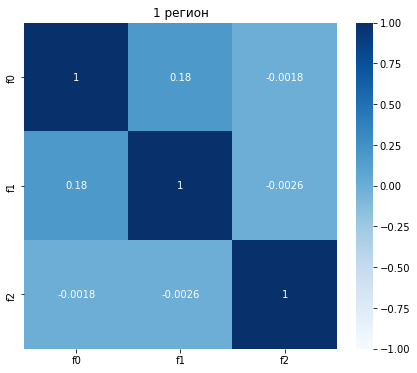

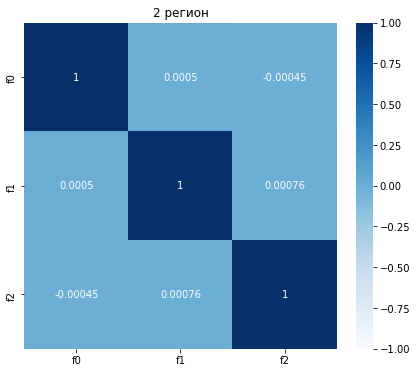

In [14]:
i=0
df=[df0,df1,df2]
for df_ in df:
    plt.figure(figsize=(7,6))
    corr = df_[['f0','f1','f2']].corr()
    sns.heatmap(corr, cmap=sns.color_palette("Blues", 1000), 
                vmin=-1, center=0, annot=True).set(title=str(i)+' регион')
    plt.show()
    i += 1

Коэффициенты корреляции очень низкие или низкие (согласно шкале Чеддока). Посмотрим на выбросы в данных.

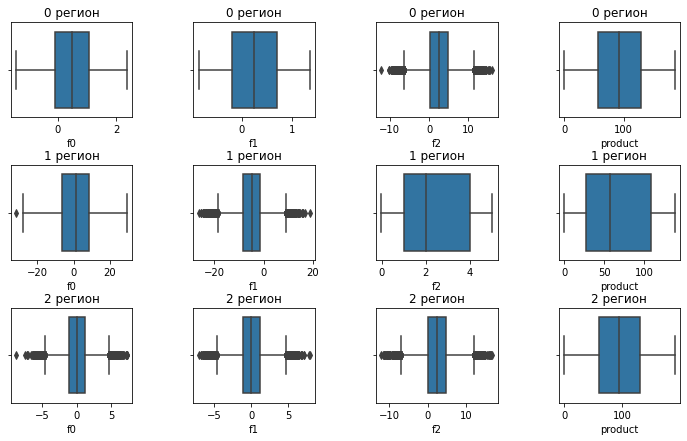

In [15]:
i=-1
df=[df0,df1,df2]
columns =['f0', 'f1', 'f2', 'product']
fig, ax = plt.subplots(3, 4, figsize=(12,7) )
plt.subplots_adjust(wspace=.5, hspace=.5)
for df_ in df:
    i +=1
    j=0
    for col in columns: 
        sns.boxplot(x=df_[col],ax=ax[i][j], orient="h").set(title=str(i)+' регион')
        j +=1   

Выбросов нет тоько в таргете 'product' — объём запасов в скважине (тыс. баррелей). В первом регине выбросы только по признаку f2. Во втором по f0 и f1. В третьем же регионе выбросы по признакам есть по f0, f1 и f2. <br> Пока оставим их как есть. Если с моделью будут сложности, можем вернуться к вопросу удаления выбросов. Их достаточно много, чтобы удалить. По крайней мере сейчас.

**Вывод** По признакам f0, f1 и f2 есть выбосы. Для дальнейшей работы мы оставляем данные как есть. Если возникнут сложности с моделью, можем вернуться к вопросу удаления выбросов.

## Обучение и проверка модели

Напишем функцию для разделения выборок на тестовую и валидационную.

In [16]:
def spliting(df):
    target = df['product']
    features = df[['f0','f1','f2']]
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
    target, test_size=0.25, random_state=12345)
    return features_train, features_valid, target_train, target_valid

Вызовем функцию для получения тестовых и валидационых фичей и таргетов по каждому региону. Для проверки верности разбиения добавим вывод shape после разбиения.

In [17]:
features_train_ = []
features_valid_= []
target_train_ = []
target_valid_ = []
i=0
df=[df0,df1,df2]
for df_ in df:
    features_train, features_valid, target_train, target_valid = spliting(df_)
    features_train_.append(features_train)
    features_valid_.append(features_valid)
    target_train_.append(target_train)
    target_valid_.append(target_valid)
    i += 1
for i in range(3):    
    print(features_train_[i].shape, features_valid_[i].shape, 
          target_train_[i].shape, target_valid_[i].shape)

(74985, 3) (24995, 3) (74985,) (24995,)
(74994, 3) (24998, 3) (74994,) (24998,)
(74994, 3) (24998, 3) (74994,) (24998,)


Согласно заданию мы будем работать только с линейной регрессией. Напишем функцию. Она будет Обучать модель, сделает предсказания на валидационной выборке и сохранит предсказания. Помимо это рассчитает RMSE модели.

In [18]:
def modeling(features_train,target_train,features_valid,target_valid):
    model=LinearRegression()
    parameters = {'fit_intercept':[True,False], 
                  'normalize':[True,False], 'copy_X':[True, False]}
    grid = GridSearchCV(model,parameters, cv=None)
    grid.fit(features_train, target_train)
    predicted = grid.predict(features_valid)
    #predicted.index = target_valid.index
    rmse = mean_squared_error(target_valid,predicted)**0.5
    return rmse,predicted.mean(),predicted,grid.best_estimator_


Запустим в функцию наши признаки и таргеты по тренировочной и валидационной выборкам. Напечатаем RMSE модели и средний предсказанный запас сырья.

In [19]:
rmse_=[]
predicted_mean_=[]
predicted_ = []
model1_=[]
for i in range(3): 
    rmse, predicted_mean, predicted, model1 = modeling(features_train_[i], target_train_[i],
                                           features_valid_[i],  target_valid_[i])
    rmse_.append(rmse)
    predicted_mean_.append(round(predicted_mean,2))
    predicted_.append(predicted)
    model1_.append(model1)
    print(f'{i} регион')
    print('Средний запас предсказанного сырья:',predicted_mean_[i])
    print('RMSE модели:',round(rmse_[i],2))

0 регион
Средний запас предсказанного сырья: 92.42
RMSE модели: 37.72
1 регион
Средний запас предсказанного сырья: 68.98
RMSE модели: 0.89
2 регион
Средний запас предсказанного сырья: 95.12
RMSE модели: 39.98


**Вывод:** <br>**1.** Корень от среднеквадратичной ошибки RMSE показывает насколько хорошо работает модель. По полученным данным, лучше всего модель работает в первом регионе. Значение 0.89 тыс. баррелей. При среднем запасе предсказанного сырья 68.98 тыс. баррелей.<br>**2.** Cредний запас предсказанного сырья по 0 и 2 региону примерно равны: 92.42 тыс. баррелей и 95.12 тыс. баррелей соответвтенно. При этом RMSE 37.72 и 39.97  тыс. баррелей.<br> **3.** Опираясь на средние запасы сырья перспетивными кажутся 0 и 2 регион. Посмотрим, что покажут расчеты.<br> **4.** Линейная регрессия наиболее оптимальна для работы, так как испоьзуется малое число параметров и она значительно меньше склонна к переобучению.

## Подготовка к расчёту прибыли

Подготовимся к расчету прибыли. Наша задача звучит следующим образом:
<br>При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают **200 лучших для разработки**.
<br>Бюджет на разработку скважин в регионе — **10 млрд рублей**.
<br>При нынешних ценах один баррель сырья приносит 450 рублей дохода. **Доход с каждой единицы продукта составляет 450 тыс. рублей**, поскольку объём указан в тысячах баррелей.
<br>После оценки рисков **нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Зададим следующие данные задачи. У нас будет 200 точек. Переменная POINTS. Доход с каждой единицы продукта составляет 450 тыс. рублей.Переменная PRICE_PER_UNIT. Бюджет на разработку скважин в регионе — 10 млрд рублей. Переменная BUDGET.

In [20]:
POINTS = 200
PRICE_PER_UNIT = 450000
BUDGET = 10000000000

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Бюджет 10 млр руб. Всего 200 скважин. С единицы продукта мы получаем 450000 руб. Получается нужно разделить общий бюджет на произведение кол-ва точек и цены за единицу продука. 

In [21]:
min_break_even_product = round(BUDGET/(POINTS*PRICE_PER_UNIT),2)
min_break_even_product

111.11

Сравним полученный объём сырья со средним запасом в каждом регионе.

In [22]:
for i in range(3):
    print('Средний запас предсказанного сырья:',predicted_mean_[i])

Средний запас предсказанного сырья: 92.42
Средний запас предсказанного сырья: 68.98
Средний запас предсказанного сырья: 95.12


**Вывод по этапу подготовка к расчету прибыли** получается, если ориентироваться по среднему, то ни один регион нас не устроит. Но это же среднее. При выборе 200 лучших значение может значительно повыситься. Посмотрим данные более детально. 

## Расчёт прибыли и рисков 

Напишим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
1. Выберем скважины с максимальными значениями предсказаний.
2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитаем прибыль для полученного объёма сырья.

In [23]:
def profit_calculation(target, predict,count):
    probs_sorted = predict.sort_values(ascending=False)
    selected = target[probs_sorted.index][:POINTS]
    return PRICE_PER_UNIT * selected.sum()-BUDGET

In [24]:
profit=[]
for i in range(3):
    target_val = pd.Series(target_valid_[i])
    predicte = pd.Series(predicted_[i])
    target_val= target_val.reset_index(drop=True)
    profit.append(profit_calculation(target_val, predicte,POINTS))
    print(f'Прибыль с {i} региона для полученного объёма сырья {round(profit[i]/1000000000,2)} млдр')
    
    

Прибыль с 0 региона для полученного объёма сырья 3.14 млдр
Прибыль с 1 региона для полученного объёма сырья 2.42 млдр
Прибыль с 2 региона для полученного объёма сырья 2.47 млдр


Создадим подвыборки для Bootstrap.

In [25]:
state = np.random.RandomState(12345)

In [26]:
for j in range(3):
    values = []
    negative_values = []
    risk = []
    for i in range(1000):
        target_val = pd.Series(target_valid_[j])
        predicte = pd.Series(predicted_[j])
        target_val= target_val.reset_index(drop=True)
        target_subsample  = target_val.sample(n=500, replace=True, random_state=state)
        probs_subsample = predicte[target_subsample.index]
        target_subsample=pd.Series(target_subsample)
        probs_subsample=pd.Series(probs_subsample)
        values.append(profit_calculation(target_subsample, probs_subsample, POINTS))

    values = pd.Series(values)
    lower = values.quantile(0.025) 
    highter = values.quantile(0.975)
    
    mean = values.mean()
    for val in values:
        if val<0:
            negative_values.append(abs(val))
    negative_values = pd.Series(negative_values)
    risk=round(negative_values.sum()/values.sum()*100,2)
    print(f'Средняя прибыль с {j} региона техникой Bootstrap {round((mean)/1000000000,2)} млрд.') 
    print(f'95% доверительный интервал {j} региона: ({round(lower/1000000000,2)},{round(highter/1000000000,2)}) млрд.')
    print(f'Риск убытков {j} региона: {risk} %')
    print()

Средняя прибыль с 0 региона техникой Bootstrap 0.46 млрд.
95% доверительный интервал 0 региона: (-0.09,0.99) млрд.
Риск убытков 0 региона: 1.28 %

Средняя прибыль с 1 региона техникой Bootstrap 0.52 млрд.
95% доверительный интервал 1 региона: (0.13,0.96) млрд.
Риск убытков 1 региона: 0.07 %

Средняя прибыль с 2 региона техникой Bootstrap 0.34 млрд.
95% доверительный интервал 2 региона: (-0.2,0.85) млрд.
Риск убытков 2 региона: 4.28 %



**Вывод** Нужно выбрать лишь те регионы, в которых вероятность убытков меньше 2.5%. Это 0ой и 1ый регионы. <br> Получается, что лучший это 1ый регион, где средняя прибыль составляет 0.52 млрд., доверительный интервал (0.13,0.96) млрд. Именно там следует начать разработку.